# Import needed library

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm

import tensorflow as tf

from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from collections import Counter
import itertools
from itertools import count
from typing import Dict, List, Iterable, Optional, Callable

from nltk.translate.bleu_score import corpus_bleu

2025-10-29 06:50:14.572610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761720614.845024      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761720614.917902      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Create vocab from dictionary

In [44]:
class MyVocab:
    def __init__(
        self,
        image_to_captions_mapping: Optional[Dict[str, List[str]]] = None,
        texts: Optional[Iterable[str]] = None,
        max_seq_len: int = 256,
        tokenize: Optional[Callable[[str], List[str]]] = None,
    ) -> None:
        if image_to_captions_mapping is None and texts is None:
            raise ValueError("Provide either image_to_captions_mapping or texts")
            
        # Tokenizer
        self.tokenize: Callable[[str], List[str]] = (
            tokenize if tokenize is not None else (lambda s: s.split(" "))
        )
        
        # Collect captions
        if image_to_captions_mapping is not None:
            captions: List[str] = list(
                itertools.chain.from_iterable(image_to_captions_mapping.values())
            )
        else:
            captions = list(texts)

        words = list(itertools.chain.from_iterable([self.tokenize(cap).split(" ") for cap in captions]))
        counter = Counter(words)

        #Special token
        self.special_tokens = ["<unk>", "<pad>", "<bos>", "<eos>"]
        self.special_ids = [0, 1, 2, 3]
        self.max_seq_len = max_seq_len
        self.counter = counter

        # Assign ids to regular tokens starting from 4
        self.vocab = {key: i for i, key in zip(count(start=4), counter.keys())}
        # Inject specials
        for tok_id, token in zip(self.special_ids, self.special_tokens):
            self.vocab[token] = tok_id
        # Sort by id to keep a stable mapping
        self.vocab = {k: v for k, v in sorted(self.vocab.items(), key=lambda x: x[1])}

        self.id2word = {v: k for k, v in self.vocab.items()}

        # Convenience handles
        self.bos_token = "<bos>"
        self.eos_token = "<eos>"
        self.pad_token = "<pad>"
        self.unk_token = "<unk>"

    def get_vocab(self) -> Dict[str, int]:
        return self.vocab

    def get_vocab_dump(self) -> Dict[str, object]:
        return {
            "itos": [self.id2word[i] for i in range(len(self.id2word))],
            "stoi": self.vocab,
            "freqs": dict(self.counter),
        }

    def encode(self, text: str) -> List[int]:
        return [self.vocab.get(w, self.vocab[self.unk_token]) for w in self.tokenize(text).split(" ")]

    def decode(self, token_ids: List[int], skip_special: bool = True) -> str:
        special = set(self.special_ids) if skip_special else set()
        return " ".join([self.id2word[t] for t in token_ids if t not in special])

    def texts_to_sequences(self, texts: Iterable[str]) -> List[List[int]]:
        return [self.encode(t) for t in texts]

    def batch_decode(self, predictions_ids: Iterable[Iterable[int]]) -> List[str]:
        special = set(self.special_ids)
        return [
            " ".join([self.id2word[t] for t in seq if t not in special])
            for seq in predictions_ids
        ]



In [3]:
!pip install python-rdrsegmenter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 kB 6.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.5 MB/s eta 0:00:0000:01


In [4]:
# Setting the input and output directory
INPUT_DIR = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images'
OUTPUT_DIR = '/kaggle/working'

# Tensorboard setting up

In [45]:
import tensorflow as tf

class TensorBoardMetrics(tf.keras.callbacks.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.log_dir = log_dir
        self.writer = tf.summary.create_file_writer(log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        with self.writer.as_default():
            try:
                lr = self.model.optimizer.learning_rate
                if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
                    global_step = self.model.optimizer.iterations
                    lr_value = float(lr(global_step))
                else:
                    lr_value = float(tf.keras.backend.get_value(lr))
                tf.summary.scalar('learning_rate', lr_value, step=epoch)
            except Exception as e:
                pass
            # Log validation metrics
            if 'val_loss' in logs:
                tf.summary.scalar('val_loss', logs['val_loss'], step=epoch)
                
            # Log training metrics
            if 'loss' in logs:
                tf.summary.scalar('train_loss', logs['loss'], step=epoch)

        self.writer.flush()

custom_metrics_callback = TensorBoardMetrics(OUTPUT_DIR)

# Image features extraction

In [46]:
# model_0 = VGG16()
model = ResNet101()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_9[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 42,552,832 (162.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

None


# Extract features from dataset

In [48]:
image_features = {}

img_dir = INPUT_DIR

problematic_images = []

for img_name in tqdm(os.listdir(img_dir)):
    try:
        img_path = os.path.join(img_dir, img_name)
        
        if os.path.isdir(img_path):
            print(f"Skipping directory: {img_name}")
            problematic_images.append(f"Directory: {img_name}")
            continue
            
        if not os.path.isfile(img_path):
            print(f"Skipping non-file: {img_name}")
            problematic_images.append(f"Non-file: {img_name}")
            continue
            
        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
        if not any(img_name.lower().endswith(ext) for ext in valid_extensions):
            print(f"Skipping non-image file: {img_name}")
            problematic_images.append(f"Non-image file: {img_name}")
            continue
        
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        image_feature = model.predict(image, verbose=0)
        image_id = img_name.split('.')[0]
        image_features[image_id] = image_feature
        
    except Exception as e:
        print(f"Error processing {img_name}: {str(e)}")
        problematic_images.append(f"Error: {img_name} - {str(e)}")
        continue

# Save problematic images to a log file
if problematic_images:
    log_file_path = os.path.join(OUTPUT_DIR, 'problematic_images_log.txt')
    with open(log_file_path, 'w') as log_file:
        log_file.write("Problematic Images Log\n")
        log_file.write("=" * 50 + "\n")
        for item in problematic_images:
            log_file.write(item + "\n")
    print(f"Logged {len(problematic_images)} problematic images to: {log_file_path}")
else:
    print("No problematic images found!")

print(f"Successfully processed {len(image_features)} images")

In [ ]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features_5k.pkl'), 'wb'))

In [49]:
# Load features from pickle file
pickle_file_path = "/kaggle/input/image-feature-26k/img_features.pkl"
with open(pickle_file_path, 'rb') as file:
    image_features = pickle.load(file)

# Load captions data

In [50]:
import pandas as pd

df = pd.read_csv("/kaggle/input/flickr30k-image-captioning-vietnamese/flickr30k_vinai_translated_full.csv")
df.head()

,image_name,comment_0,comment_1,comment_2,comment_3,comment_4,vinai_comment_0,vinai_comment_1,vinai_comment_2,vinai_comment_3,vinai_comment_4
0,../input/flickr-image-dataset/flickr30k_images...,Two young guys with shaggy hair look at their...,"Two young , White males are outside near many...",Two men in green shirts are standing in a yard .,A man in a blue shirt standing in a garden .,Two friends enjoy time spent together .,Hai chàng trai trẻ với mái tóc xù nhìn vào bàn...,"Hai con đực non, trắng đang ở bên ngoài gần nh...",Hai người đàn ông mặc áo xanh đang đứng trong ...,Một người đàn ông mặc áo xanh đứng trong vườn .,Hai người bạn tận hưởng thời gian dành cho nhau.
1,../input/flickr-image-dataset/flickr30k_images...,Several men in hard hats are operating a gian...,Workers look down from up above on a piece of...,Two men working on a machine wearing hard hats .,Four men on top of a tall structure .,Three men on a large rig .,Vài người đàn ông đội mũ cứng đang vận hành mộ...,Công nhân nhìn xuống từ trên cao trên một thiế...,Hai người đàn ông làm việc trên một cỗ máy đội...,Bốn người đàn ông trên đỉnh của một cấu trúc cao.,Ba người trên một giàn khoan lớn.
2,../input/flickr-image-dataset/flickr30k_images...,A child in a pink dress is climbing up a set ...,A little girl in a pink dress going into a wo...,A little girl climbing the stairs to her play...,A little girl climbing into a wooden playhouse,A girl going into a wooden building .,Một đứa trẻ trong một chiếc váy màu hồng đang ...,Một cô bé mặc váy hồng đi vào một căn chòi gỗ.,Một cô bé trèo lên cầu thang đến nhà chơi của ...,Một cô bé trèo vào một ngôi nhà gỗ,Một cô gái đi vào một tòa nhà bằng gỗ .
3,../input/flickr-image-dataset/flickr30k_images...,Someone in a blue shirt and hat is standing o...,A man in a blue shirt is standing on a ladder...,A man on a ladder cleans the window of a tall...,man in blue shirt and jeans on ladder cleanin...,a man on a ladder cleans a window,Có ai đó mặc áo sơ mi xanh và đội mũ đang đứng...,Một người đàn ông mặc áo xanh đang đứng trên t...,Một người đàn ông trên thang lau cửa sổ của mộ...,người đàn ông trong áo sơ mi màu xanh và quần ...,Một người đàn ông trên thang lau cửa sổ.
4,../input/flickr-image-dataset/flickr30k_images...,"Two men , one in a gray shirt , one in a blac...",Two guy cooking and joking around with the ca...,Two men in a kitchen cooking food on a stove .,Two men are at the stove preparing food .,Two men are cooking a meal .,"Hai người đàn ông, một người mặc áo xám, một n...",Hai người đàn ông nấu ăn và đùa giỡn xung quan...,Hai người đàn ông trong một nhà bếp nấu ăn trê...,Hai người đàn ông đang ở bếp chuẩn bị thức ăn.,Hai người đàn ông đang nấu ăn.


In [51]:
df1 = pd.read_csv("/kaggle/input/flickr30k-image-captioning-vietnamese/flickr30k_vinai_translated_full.csv")

In [10]:
# image_features.keys()
# loaded_features.keys()

# Create image_caption_mapping dictionary

In [52]:
image_to_captions_mapping = defaultdict(list)

successful_image_ids = set(image_features.keys())
print(f"Number of images with successfully extracted features: {len(successful_image_ids)}")

for i, row in df.iterrows():
    image_id = row["image_name"].split("/")[-1]
    captions = df.iloc[i, 1:6].values.tolist()
    image_id = image_id.replace('.jpg', '')
    
    if image_id in successful_image_ids:
        image_to_captions_mapping[image_id] = captions
    else:
        print(f"Skipping captions for image {image_id} - no features extracted")

total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)
print("Total number of images with both features and captions:", len(image_to_captions_mapping))

Number of images with successfully extracted features: 31783
Total number of captions: 158915
Total number of images with both features and captions: 31783


In [53]:
image_to_captions_mapping_vie = defaultdict(list)

successful_image_ids_vie = set(image_features.keys())
print(f"Number of images with successfully extracted features: {len(successful_image_ids)}")

for i, row in df.iterrows():
    image_id = row["image_name"].split("/")[-1]
    captions = df.iloc[i, 6:11].values.tolist()
    image_id = image_id.replace('.jpg', '')
    
    if image_id in successful_image_ids_vie:
        image_to_captions_mapping_vie[image_id] = captions
    else:
        print(f"Skipping captions for image {image_id} - no features extracted")

total_captions_vie = sum(len(captions) for captions in image_to_captions_mapping_vie.values())
print("Total number of captions:", total_captions_vie)
print("Total number of images with both features and captions:", len(image_to_captions_mapping_vie))

Number of images with successfully extracted features: 31783
Total number of captions: 158915
Total number of images with both features and captions: 31783


In [54]:
image_to_captions_mapping_vie["1000092795"]

['Hai chàng trai trẻ với mái tóc xù nhìn vào bàn tay của họ trong khi treo ra trong sân .',
 'Hai con đực non, trắng đang ở bên ngoài gần nhiều bụi cây.',
 'Hai người đàn ông mặc áo xanh đang đứng trong sân.',
 'Một người đàn ông mặc áo xanh đứng trong vườn .',
 'Hai người bạn tận hưởng thời gian dành cho nhau.']

# Preprocessing Captions: Getting Them Ready

# Clean token function

In [55]:
from python_rdrsegmenter import load_segmenter
segmenter = load_segmenter()

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            caption = caption.replace('\s+', ' ')
            caption = '[SOS] ' + ' '.join([word for word in segmenter.tokenize(caption).split() if len(word) > 1]) + ' [EOS]'
            captions[i] = caption

In [56]:
# # before preprocess of text
# image_to_captions_mapping['1000092795']

In [59]:
image_to_captions_mapping_vie['10002456']

['Vài người đàn ông đội mũ cứng đang vận hành một hệ thống ròng rọc khổng lồ.',
 'Công nhân nhìn xuống từ trên cao trên một thiết bị.',
 'Hai người đàn ông làm việc trên một cỗ máy đội mũ cứng.',
 'Bốn người đàn ông trên đỉnh của một cấu trúc cao.',
 'Ba người trên một giàn khoan lớn.']

In [60]:
# preprocess the text
clean(image_to_captions_mapping)

In [61]:
clean(image_to_captions_mapping_vie)

In [62]:
# image_to_captions_mapping['1000092795']

In [63]:
image_to_captions_mapping_vie['1000092795']

['[SOS] hai chàng trai_trẻ với mái_tóc xù nhìn vào bàn_tay của họ trong khi treo ra trong sân [EOS]',
 '[SOS] hai con đực non trắng đang bên ngoài gần nhiều bụi cây [EOS]',
 '[SOS] hai người đàn_ông mặc áo xanh đang đứng trong sân [EOS]',
 '[SOS] một người đàn_ông mặc áo xanh đứng trong vườn [EOS]',
 '[SOS] hai người bạn tận_hưởng thời_gian dành cho nhau [EOS]']

In [64]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [65]:
all_captions_vie = [caption for captions in image_to_captions_mapping_vie.values() for caption in captions]

In [68]:
# all_captions[:10]

In [69]:
all_captions_vie[:10]

['[SOS] hai chàng trai_trẻ với mái_tóc xù nhìn vào bàn_tay của họ trong khi treo ra trong sân [EOS]',
 '[SOS] hai con đực non trắng đang bên ngoài gần nhiều bụi cây [EOS]',
 '[SOS] hai người đàn_ông mặc áo xanh đang đứng trong sân [EOS]',
 '[SOS] một người đàn_ông mặc áo xanh đứng trong vườn [EOS]',
 '[SOS] hai người bạn tận_hưởng thời_gian dành cho nhau [EOS]',
 '[SOS] vài người đàn_ông_đội mũ cứng đang vận_hành một hệ_thống ròng_rọc khổng_lồ [EOS]',
 '[SOS] công_nhân nhìn xuống từ trên cao trên một thiết_bị [EOS]',
 '[SOS] hai người đàn_ông làm_việc trên một cỗ máy đội mũ cứng [EOS]',
 '[SOS] bốn người đàn_ông trên đỉnh của một cấu_trúc cao [EOS]',
 '[SOS] ba người trên một giàn khoan lớn [EOS]']

In [70]:
# preprocess the text
from typing import List

from python_rdrsegmenter import load_segmenter
segmenter = load_segmenter()

def build_vi_tokenizer(caption):
    return segmenter.tokenize(caption).split(" ")
vi_tokenize_list = []
for caption in all_captions_vie:
    vi_tokenize_list += build_vi_tokenizer(caption)

In [71]:
vi_tokenize_list[:10]

['[SOS]',
 'hai',
 'chàng',
 'trai_trẻ',
 'với',
 'mái_tóc',
 'xù',
 'nhìn',
 'vào',
 'bàn_tay']

In [75]:
save_path = "/kaggle/working/vi_tokenize_list.txt"
with open(save_path, "w", encoding="utf-8") as f:
    for w in vi_tokenize_list:
        f.write(f"{w}\n")
print("Saved to:", save_path)

Saved to: /kaggle/working/vi_tokenize_list.txt


In [27]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [76]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 19752
Maximum Caption Length: 74


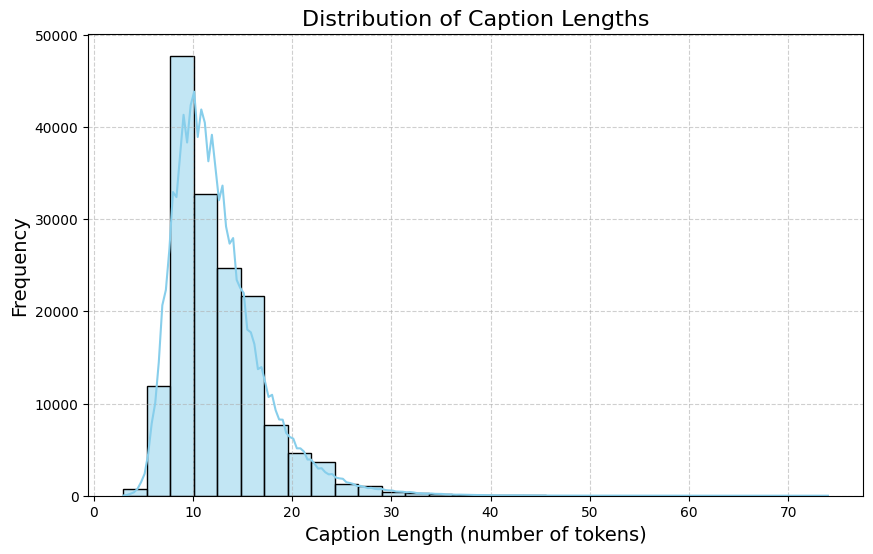

Min length: 3
Max length: 74
Mean length: 12.524670421294402


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

caption_lengths = [len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions]

plt.figure(figsize=(10, 6))
sns.histplot(caption_lengths, bins=30, kde=True, color='skyblue')

plt.title('Distribution of Caption Lengths', fontsize=16)
plt.xlabel('Caption Length (number of tokens)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Min length:", min(caption_lengths))
print("Max length:", max(caption_lengths))
print("Mean length:", sum(caption_lengths)/len(caption_lengths))


# Train Test Split

In [78]:
image_ids = list(image_to_captions_mapping.keys())

print(f"Total image IDs: {len(image_ids)}")

np.random.seed(42)
np.random.shuffle(image_ids)

# Split into Train, Validation, and Test sets (70%, 15%, 15%)
train_split = int(len(image_ids) * 0.70)
val_split = int(len(image_ids) * 0.85)

train = image_ids[:train_split]
validation = image_ids[train_split:val_split]
test = image_ids[val_split:]

print(f"Training set: {len(train)} images")
print(f"Validation set: {len(validation)} images")
print(f"Test set: {len(test)} images")
print(f"Total: {len(train) + len(validation) + len(test)} images")

assert len(train) + len(validation) + len(test) == len(image_ids), "Split doesn't add up correctly!"

Total image IDs: 31783
Training set: 22248 images
Validation set: 4767 images
Test set: 4768 images
Total: 31783 images


In [79]:
max_caption_length = 30
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    batch_count = 0

    while True:
        for image_id in data_keys: 
            captions = image_to_captions_mapping[image_id]

            for caption in captions:
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(caption_seq)):
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1_batch.append(features[image_id][0])
                    X2_batch.append(in_seq)
                    y_batch.append(out_seq)

                    batch_count += 1

                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield (X1_batch, X2_batch), y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

In [80]:
import datetime
from tensorflow.keras.callbacks import TensorBoard
log_dir = os.path.join(OUTPUT_DIR, "logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1,
    write_steps_per_second=True,
)

print(f"TensorBoard logs will be saved to: {log_dir}")
print("To view TensorBoard, run: tensorboard --logdir=" + log_dir)

TensorBoard logs will be saved to: /kaggle/working/logs/fit/20251029-072354
To view TensorBoard, run: tensorboard --logdir=/kaggle/working/logs/fit/20251029-072354


# LSTM Model Training

In [100]:
# 1. Image Encoder
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(256, activation='relu', name='image_feature_dense')(fe1)

# 2. Sequence Decoder
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256)(inputs2)
se2 = Dropout(0.3)(se1)
# LSTM
se3 = LSTM(256, name='sequence_lstm')(se2) 

# 3. Decoder
decoder_input = concatenate([fe2, se3], name='merge_features')
decoder1 = Dense(256, activation='relu', name='decoder_dense_1')(decoder_input)
outputs = Dense(vocab_size, activation='softmax', name='final_output')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile with learning rate scheduling
initial_learning_rate = 1e-4

model.compile(loss='categorical_crossentropy', 
              optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True)
print(model.summary())

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 30, 256)   │  5,056,512 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 4096)      │          0 │ input_layer_14[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 30, 256)   │          0 │ embedding_6[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_feature_dense │ (None, 256)       │  1,048,832 │ dropout_12[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_lstm       │ (None, 256)       │    525,312 │ dropout_13[0][0]  │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_features      │ (None, 512)       │          0 │ image_feature_de… │
│ (Concatenate)       │                   │            │ sequence_lstm[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_1     │ (None, 256)       │    131,328 │ merge_features[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 19752)     │  5,076,264 │ decoder_dense_1[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,838,248 (45.16 MB)

 Trainable params: 11,838,248 (45.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [101]:
callbacks = [
    ReduceLROnPlateau(
        learning_rate = 1e-4,
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tensorboard_callback,
    custom_metrics_callback
]

In [102]:
print(callbacks)

[<keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x7bf53a304ad0>, <keras.src.callbacks.tensorboard.TensorBoard object at 0x7bf5445ef590>, <__main__.TensorBoardMetrics object at 0x7bf5e38e1ed0>]


In [103]:
# Set the number of epochs, batch size
epochs = 10
batch_size = 128

steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(validation) / batch_size)

train_generator = data_generator(train, image_to_captions_mapping, image_features, tokenizer, max_caption_length, vocab_size, batch_size)
validation_generator = data_generator(validation, image_to_captions_mapping, image_features, tokenizer, max_caption_length, vocab_size, batch_size)

history = model.fit(
    train_generator, 
    epochs=epochs, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 7.0682 - val_loss: 6.0217 - learning_rate: 0.0010
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 5.9330 - val_loss: 5.8342 - learning_rate: 0.0010
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 5.5858 - val_loss: 5.3783 - learning_rate: 0.0010
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 5.3254 - val_loss: 5.2517 - learning_rate: 0.0010
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 5.2462 - val_loss: 5.2463 - learning_rate: 0.0010
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 5.0902 - val_loss: 5.2022 - learning_rate: 0.0010
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 5.0312 - val_loss: 4.9408 - learning_rate: 0.0010
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 4.8620 - val_loss: 4.9394 - learning_rate: 0.0010
Epoch 9/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 5.0051 - val_loss: 4.8307 - learning_rate: 0.0010


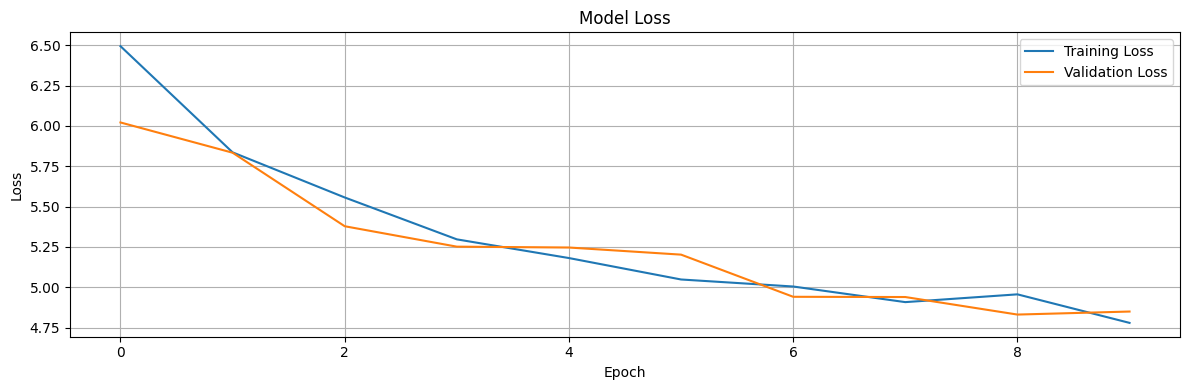

Final Training Loss: 4.7791
Final Validation Loss: 4.8494


In [104]:
# Plot training history to analyze overfitting
plt.figure(figsize=(12, 4))

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


In [105]:
# Save the model
model.save(OUTPUT_DIR+'/best_model_30k_lstm.h5')

# Captions Generation

# Predicting captions for Images

In [106]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [107]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    caption = '[SOS]'
    
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        yhat = model.predict([image_features, sequence], verbose=0)
        predicted_index = np.argmax(yhat)
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        
        caption += " " + predicted_word
        
        if predicted_word is None or predicted_word == '[EOS]':
            break
    
    return caption

In [121]:
actual_captions_list = []
predicted_captions_list = []
test = test[:100]
for key in tqdm(test):
    actual_captions = image_to_captions_mapping[key]
    predicted_caption = predict_caption(model, image_features[key], tokenizer, max_caption_length)
    
    actual_captions_words = [caption.split() for caption in actual_captions]
    predicted_caption_words = predicted_caption.split()
    
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 100/100 [04:04<00:00,  2.44s/it]

BLEU-1: 0.188710
BLEU-2: 0.098103


In [109]:
test[:10]

['4958897418',
 '426065353',
 '3551447084',
 '4655435447',
 '4674228685',
 '6272230270',
 '3334537556',
 '7357208586',
 '2432061076',
 '2586028627']

In [110]:
# Function for generating caption
NEW_DIR = ""
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, image_features[image_id], tokenizer, max_caption_length)
    y_pred = y_pred.replace("[SOS]", "")
    y_pred = y_pred.replace("eos", "")
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)